In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ds = xr.load_dataset('D:\\thesis\\CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly.nc')

In [3]:
lat_bounds = slice(44.75, 46.65)
lon_bounds = slice(8.5, 11.25)

agl = ds.agl.sel(lat=lat_bounds, lon=lon_bounds)

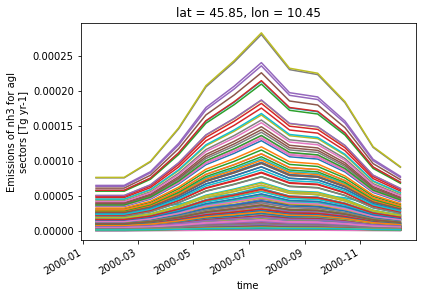

In [4]:
plt.figure()
for i in range(12):
    for j in range(20):
        agl[:, i, j][0:12].plot()

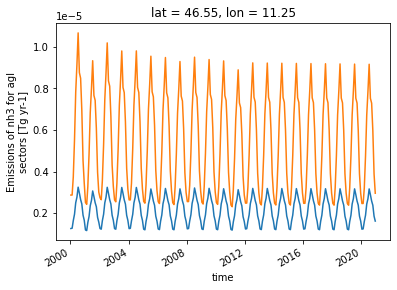

In [5]:
plt.figure()
agl[:, 0, 0].plot()
agl[:, -1, -1].plot()

<AxesSubplot:>

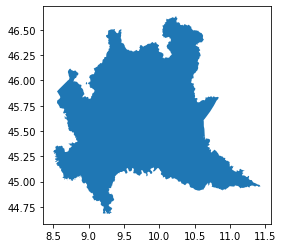

In [6]:
import geopandas as gpd
from shapely.geometry import Point

from shapely import speedups
speedups.disable()


df = gpd.read_file('..\\resources\\Regione_10000_CT10_polygon\\Regione_10000_CT10_polygon.shp')

df.to_crs(epsg=4326, inplace=True)
df.plot()

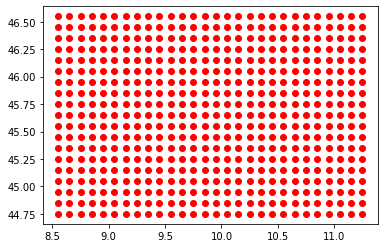

In [7]:
lats = agl.lat
lons = agl.lon

coords = [(lat, lon) for lat in lats.to_series() for lon in lons.to_series().tolist()]

lats = [coord[0] for coord in coords]
lons = [coord[1] for coord in coords]

plt.scatter(lons, lats, c='r')


In [8]:
grid = [ (round(lat, 2), round(lon, 2)) for lat, lon in zip(lats, lons) if df.geometry.contains(Point(lon, lat)).bool()]

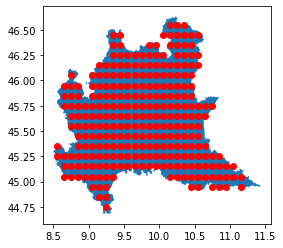

In [9]:
lats = [coord[0] for coord in grid]
lons = [coord[1] for coord in grid]

df.plot()
plt.scatter(lons, lats, c='r')

plt.show()

agl.to_netcdf('agl_lombardia.nc')

In [10]:
agl_lats = [round(lat, 2) for lat in agl.lat.to_series().tolist()]
agl_lons = [round(lon, 2) for lon in agl.lon.to_series().tolist()]

data = np.zeros((len(agl_lats), len(agl_lons)))
data.fill(np.nan)

for lat_idx, lat in enumerate(agl_lats):
    for lon_idx, lon in enumerate(agl_lons):
        if (lat, lon) in grid:
            data[lat_idx][lon_idx] = np.mean(agl[:12, lat_idx, lon_idx].to_series().tolist())

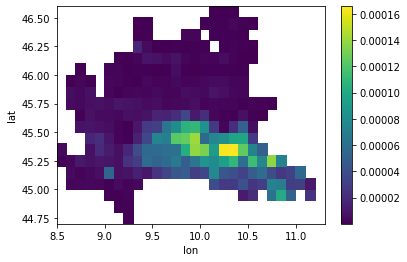

In [11]:
mean_agl = xr.DataArray(data, coords=[agl_lats, agl_lons], dims=['lat', 'lon'])
mean_agl.plot()

In [12]:
ts_data = np.ones((252, len(agl_lats), len(agl_lons)))
ts_data.fill(np.nan)

for lat_idx, lat in enumerate(agl_lats):
    for lon_idx, lon in enumerate(agl_lons):
        if (lat, lon) in grid:
            for time_idx in range(len(agl.time.to_series().tolist())):
                ts_data[time_idx][lat_idx][lon_idx] = agl[time_idx, lat_idx, lon_idx].values

In [13]:
times = agl.time.to_series().tolist()

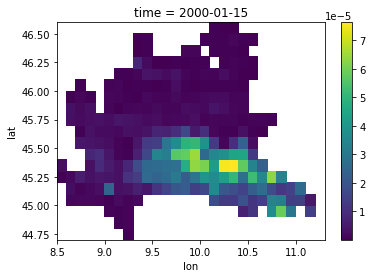

In [14]:
lombardia_ts = xr.DataArray(ts_data, coords=[times, agl_lats, agl_lons], dims=['time', 'lat', 'lon'])   
lombardia_ts[0, :, :].plot()

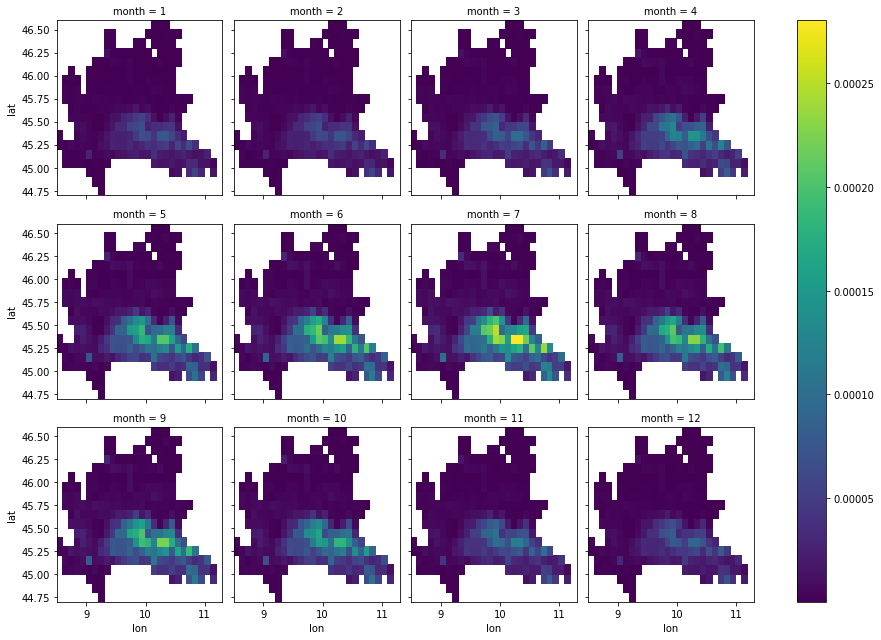

In [15]:
lombardia_ts.groupby('time.month').mean().plot(col='month', col_wrap=4)

lombardia_ts.to_netcdf('lombardia_ts.nc')